# **Multi-omics Cohort Building with Cancer Data Aggregator**

# Example use case:

This notebook aims to demonstrate building a cohort of specific data types using the Cancer Data Aggregator (CDA). We will be retrieving mutation and gene expression data stored at the Genomic Data Commons (GDC), protein intensity data stored at the Proteomic Data Commons (PDC), and in the future tumor characteristics derived from slide images stored at the Imaging Data Commons (IDC). We then demonstrate how to retrieve the desired derived data of these cases from the ISB-CGC ecosystem to immediatly feed into statistical analyses.

For more information about the CDA data and API visit their site:
https://cda.readthedocs.io

For more information about the ISB-CGC and the BigQuery Data Ecosystem visit our site:
https://isb-cgc.org

---


# Setup steps:
First we import the CDA python packages and functions we will be using.

In [ ]:
try:
  from itables import(
     init_notebook_mode, show
    )
except:
  !pip install -r https://raw.githubusercontent.com/CancerDataAggregator/Community-Notebooks/main/requirements.txt


import numpy as np
import pandas as pd
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)
import itables.options as opt

opt.classes="display"
opt.buttons=["copyHtml5", "csvHtml5", "excelHtml5"]
opt.maxBytes=0

In [ ]:
from cdapython import tables, columns, column_values, fetch_rows, summary_counts

---

The `tables()` function from the CDA package simply returns a list of tables tables available. These tables each contain various information about the patients in the three Data Commons.

In [ ]:
tables()

['diagnosis',
 'file',
 'researchsubject',
 'somatic_mutation',
 'specimen',
 'subject',
 'treatment']

Considering we are interested in specific data types we can further query the columns of the `subject` table by use of the `columns()` function. This returns a set of columns, the format of the data contained in these columns, and a short description.

In [ ]:
columns(table=['subject'])

table          column data_type  nullable  \
0  subject      subject_id      text     False   
1  subject  cause_of_death      text      True   
2  subject   days_to_birth   integer      True   
3  subject   days_to_death   integer      True   
4  subject       ethnicity      text      True   
5  subject            race      text      True   
6  subject             sex      text      True   
7  subject         species      text      True   
8  subject    vital_status      text      True   

                                         description  
0  The logical identifier of the entity in the sy...  
1  Coded value indicating the circumstance or con...  
2  Number of days between the date used for index...  
3  Number of days between the date used for index...  
4  An individuals self-described social and cultu...  
5  An arbitrary classification of a taxonomic gro...  
6  The biologic character or quality that disting...  
7  The taxonomic group (e.g. species) of the pati...  
8  Coded value indicating the state or condition ...

From browsing the results we can infer that `data_type` is likely to contain the information we are after. We can further interrogate the CDA data and retrieve a list of possible values in each field via the `column_values()` which we apply to the `data_type` column.

In [ ]:
column_values('data_type')

data_type     count
0                               CT Image Storage  27638353
1                               MR Image Storage  15080283
2     Positron Emission Tomography Image Storage   1307119
3                            Enhanced SR Storage    261681
4                                           <NA>    249486
..                                           ...       ...
67              Real World Value Mapping Storage        20
68         X-Ray Radiofluoroscopic Image Storage        11
69              X-Ray Angiographic Image Storage         6
70  Digital X-Ray Image Storage - For Processing         4
71               X-Ray Radiation Dose SR Storage         1

[72 rows x 2 columns]

---

The function returns a list of possible data types associated with all subjects. We can browse this and select those pertinent to our analysis. Specifically we will be relying on the `data_type` and `data_source` fields. For example, we can retrieve all cases with Pathology Reports as below:

In [ ]:
pathology = fetch_rows(table = 'file', match_all='data_type = Pathology Report')

# Selecting data types

To simplify the cohort building process we will query for data from each data commons (genomic, proteomic, imaging) separately and then perform set operations to determine the overlap. For the genomic component of our analysis we will first retrieve a list of cases with mutation data available from the GDC, followed by the set of cases with RNA gene expression data. More information about the data processing pipelines used by the GDC can be found in their documentation.

https://gdc.cancer.gov/about-data/gdc-data-processing/genomic-data-processing

Our first query to retrieve those cases from the GDC that have **Somatic Mutation** data:

In [ ]:
gdc_mutation = fetch_rows(table="subject",
                       match_any = ["data_type = Aggregated Somatic Mutation", "data_type = data_type = Annotated Somatic Mutation"],
                       data_source = ['GDC'],
                       link_to_table='researchsubject')
gdc_mutation.head(3)

subject_id cause_of_death  days_to_birth  days_to_death ethnicity  \
0  BEATAML1.0.1002           <NA>           <NA>           <NA>      <NA>   
1  BEATAML1.0.1003           <NA>           <NA>           <NA>      <NA>   
2  BEATAML1.0.1004           <NA>           <NA>           <NA>      <NA>   

   race   sex       species vital_status          researchsubject_id  \
0  <NA>  male  Homo sapiens         Dead  BEATAML1.0-CRENOLANIB.1002   
1  <NA>  male  Homo sapiens         Dead  BEATAML1.0-CRENOLANIB.1003   
2  <NA>  male  Homo sapiens         Dead  BEATAML1.0-CRENOLANIB.1004   

  member_of_research_project primary_diagnosis_condition  \
0      BEATAML1.0-CRENOLANIB           Myeloid Leukemias   
1      BEATAML1.0-CRENOLANIB           Myeloid Leukemias   
2      BEATAML1.0-CRENOLANIB           Myeloid Leukemias   

                          primary_diagnosis_site  
0  Hematopoietic and reticuloendothelial systems  
1  Hematopoietic and reticuloendothelial systems  
2  Hematopoietic and reticuloendothelial systems

We can then further query for those cases within the GDC with **Gene Expression** data:

In [ ]:
gdc_expression = fetch_rows(table="subject",
                       match_all = ["data_type = Gene Expression Quantification"],
                       data_source = ['GDC'],
                       link_to_table='researchsubject')
gdc_expression.head(3)

subject_id cause_of_death  days_to_birth  days_to_death ethnicity  \
0  APOLLO.AP-27JZ           <NA>           <NA>           <NA>      <NA>   
1  APOLLO.AP-27JZ           <NA>           <NA>           <NA>      <NA>   
2  APOLLO.AP-27JZ           <NA>           <NA>           <NA>      <NA>   

    race   sex       species vital_status   researchsubject_id  \
0  White  male  Homo sapiens         Dead  APOLLO-LUAD.AP-27JZ   
1  White  male  Homo sapiens         Dead    PDC000434.AP-27JZ   
2  White  male  Homo sapiens         Dead    PDC000435.AP-27JZ   

  member_of_research_project   primary_diagnosis_condition  \
0                APOLLO-LUAD  Adenomas and Adenocarcinomas   
1                  PDC000434           Lung Adenocarcinoma   
2                  PDC000435           Lung Adenocarcinoma   

  primary_diagnosis_site  
0      Bronchus and lung  
1      Bronchus and lung  
2      Bronchus and lung

Swapping data commons we can look for those cases that have some **Masked Intensities**, a measure of protein abundance, from the PDC. For more information about the PDC data processing pipelines for these data check the PDC documentation below.

https://proteomic.datacommons.cancer.gov/pdc/harmonization

In [ ]:
pdc_intensity = fetch_rows(table="subject",
                           match_all=["data_type = Masked Intensities"],
                           data_source = ['PDC'],
                           link_to_table='researchsubject')
pdc_intensity.head(3)

subject_id  cause_of_death  days_to_birth  days_to_death ethnicity  \
0  CPTAC.11LU013  Cancer Related         -21627           <NA>      <NA>   
1  CPTAC.11LU013  Cancer Related         -21627           <NA>      <NA>   
2  CPTAC.11LU013  Cancer Related         -21627           <NA>      <NA>   

    race   sex       species vital_status     researchsubject_id  \
0  Asian  male  Homo sapiens         <NA>        CPTAC-3.11LU013   
1  Asian  male  Homo sapiens         <NA>  cptac_luad.11LU013.RS   
2  Asian  male  Homo sapiens         <NA>      PDC000149.11LU013   

  member_of_research_project   primary_diagnosis_condition  \
0                    CPTAC-3  Adenomas and Adenocarcinomas   
1                 cptac_luad                Adenocarcinoma   
2                  PDC000149           Lung Adenocarcinoma   

  primary_diagnosis_site  
0      Bronchus and lung  
1                   Lung  
2      Bronchus and lung

Finally for completeness we query for those cases that have **Slide Images** within the IDC. As with the other commons, more information about the data stored in the IDC and specifically the DICOM format can be found in their documentation.

https://learn.canceridc.dev/

In [ ]:
idc_slide = fetch_rows(table="subject", match_all=["data_type = Slide Image"],
                       data_source = ['IDC'],
                       link_to_table='researchsubject')
idc_slide.head(3)

subject_id cause_of_death  days_to_birth  days_to_death  \
0  TCGA.TCGA-02-0001           <NA>         -16179            358   
1  TCGA.TCGA-02-0001           <NA>         -16179            358   
2  TCGA.TCGA-02-0003           <NA>         -18341            144   

                ethnicity   race     sex       species vital_status  \
0  Not Hispanic or Latino  White  female  Homo sapiens         Dead   
1  Not Hispanic or Latino  White  female  Homo sapiens         Dead   
2  Not Hispanic or Latino  White    male  Homo sapiens         Dead   

         researchsubject_id member_of_research_project  \
0     TCGA-GBM.TCGA-02-0001                   TCGA-GBM   
1  tcga_gbm.TCGA-02-0001.RS                   tcga_gbm   
2     TCGA-GBM.TCGA-02-0003                   TCGA-GBM   

  primary_diagnosis_condition primary_diagnosis_site  
0                     Gliomas                  Brain  
1     Glioblastoma Multiforme                  Brain  
2                     Gliomas                  Brain

# Analyses

We've generated the lists of cases with the relevant data types available. With these data tables we can generate the overlap to determine our final cohort size through set operations and can retrieve the derived data directly from ISB-CGC hosted BiqQuery tables. BigQuery is a tool with unique scaling functionality allowing us to quickly perform table joins between these data tables. For more information about the ISB-CGC BigQuery ecosystem we have a short introductory video.

https://www.youtube.com/watch?v=5hVgGW346wI

We can visualize the overlap between our case lists with a venn diagram, for this we'll install the `venny4py` python package as well as a few bigquery functions and `pandas`.

In [ ]:
!pip install venny4py
from venny4py.venny4py import *
from google.cloud import bigquery
from google.colab import auth
import pandas as pd

<Figure size 1200x1200 with 0 Axes>

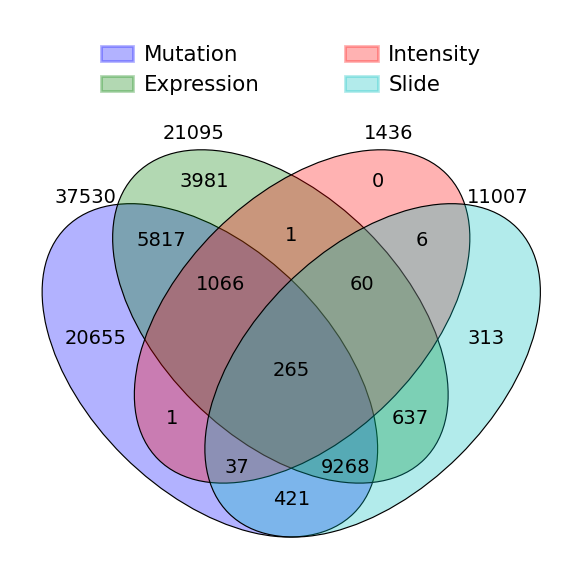

In [ ]:
sets = {
    'Mutation': set(gdc_mutation['subject_id']) - set([None]),
    'Expression': set(gdc_expression['subject_id']) - set([None]),
    'Intensity': set(pdc_intensity['subject_id']) - set([None]),
    'Slide': set(idc_slide['subject_id']) - set([None])
}

plt.figure(figsize=(4,4), dpi=300)
venny4py(sets=sets)

In [ ]:
final_set = sets['Mutation'].intersection(sets['Expression']).intersection(sets['Intensity']).intersection(sets['Slide'])
formatted_identifiers = ','.join(['"{}"'.format(x.split('.')[1]) for x in final_set])
print(','.join(final_set))

TCGA.TCGA-AG-A016,TCGA.TCGA-25-1319,TCGA.TCGA-AG-A008,TCGA.TCGA-61-2088,TCGA.TCGA-D8-A13Y,TCGA.TCGA-AG-A00Y,TCGA.TCGA-29-1774,TCGA.TCGA-AG-A02N,TCGA.TCGA-13-1507,TCGA.TCGA-AA-3664,TCGA.TCGA-29-1776,TCGA.TCGA-E2-A154,TCGA.TCGA-C8-A12V,TCGA.TCGA-24-1474,TCGA.TCGA-13-1497,TCGA.TCGA-24-2290,TCGA.TCGA-BH-A18Q,TCGA.TCGA-29-1702,TCGA.TCGA-25-1329,TCGA.TCGA-AA-3672,TCGA.TCGA-25-2409,TCGA.TCGA-A2-A0EV,TCGA.TCGA-25-2400,TCGA.TCGA-A2-A0EQ,TCGA.TCGA-61-1995,TCGA.TCGA-AO-A12D,TCGA.TCGA-24-2261,TCGA.TCGA-E2-A158,TCGA.TCGA-13-1404,TCGA.TCGA-BH-A0C7,TCGA.TCGA-BH-A0BV,TCGA.TCGA-A8-A06Z,TCGA.TCGA-AA-A024,TCGA.TCGA-AA-A01S,TCGA.TCGA-AN-A0AS,TCGA.TCGA-A2-A0T3,TCGA.TCGA-AA-A02J,TCGA.TCGA-61-1910,TCGA.TCGA-AG-A01Y,TCGA.TCGA-24-1103,TCGA.TCGA-AA-3848,TCGA.TCGA-AG-A032,TCGA.TCGA-AA-3986,TCGA.TCGA-24-1430,TCGA.TCGA-A8-A08G,TCGA.TCGA-24-1104,TCGA.TCGA-AR-A1AQ,TCGA.TCGA-C8-A12U,TCGA.TCGA-BH-A18V,TCGA.TCGA-A2-A0EY,TCGA.TCGA-AA-3561,TCGA.TCGA-61-2094,TCGA.TCGA-AO-A03O,TCGA.TCGA-C8-A138,TCGA.TCGA-E2-A159,TCGA.TCGA-

Our final overlap of cases across the four chosen data type is 265 cases, all from the TCGA project. This helpfully simplifies the process of retrieving data from the BigQuery ecosystem. To view a searchable interface of these tables we can visit the BigQuery Search Tool:

https://isb-cgc.appspot.com/bq_meta_search/

After review the data we are interested in is stored in the following tables for our genomic data types:

*  isb-cgc-bq.TCGA_versioned.RNAseq_hg38_gdc_r35
*  isb-cgc-bq.TCGA.masked_somatic_mutation_hg38_gdc_current

And for our proteomic data type:

* isb-cgc-bq.TCGA.quant_proteome_TCGA_breast_cancer_pdc_current
* isb-cgc-bq.TCGA.quant_proteome_TCGA_ovarian_JHU_pdc_current
* isb-cgc-bq.TCGA.quant_proteome_TCGA_ovarian_PNNL_pdc_current

To retrieve data from BigQuery we have to authenticate and provide a project to charge. The cost of executing the queries in this notebook total to a few cents.



In [ ]:
client = bigquery.Client("isb-cgc-notebook-dev") # replace this project with your own
auth.authenticate_user()

# BQ SQL queries


SQL queries are fundamentally very similar to Excel macros or subsetting R data frames, where the syntax of subsetting an R data frame is as follows:

    dataframe[ ,column ][ conditional ]

The equivalent operation in SQL would look like this:

    SELECT column FROM table WHERE conditional

For our first query we will retrieve the RNA sequencing fpkm values, the gene names, the project name specifically for tumor samples. We will use the identifiers retrieved from CDA to subset for only those cases in our simple cohort. For the purposes of this instructional notebook we are focusing exclusively on the gene ERBB2.

In [ ]:
expression_query = f"""
  select
    case_barcode,
    project_short_name,
    gene_name,
    fpkm_uq_unstranded,
    sample_type_name
  from `isb-cgc-bq.TCGA_versioned.RNAseq_hg38_gdc_r35`
  where case_barcode in ({formatted_identifiers})
  and gene_name = 'ERBB2'
  and sample_type_name = 'Primary Tumor'
"""
query_job = client.query(expression_query)
expr_df = query_job.result().to_dataframe()
expr_df.head(3)
#len(expr_df)

case_barcode project_short_name gene_name  fpkm_uq_unstranded  \
0  TCGA-A2-A0YL          TCGA-BRCA     ERBB2             22.1374   
1  TCGA-A2-A0YI          TCGA-BRCA     ERBB2             30.2270   
2  TCGA-BH-A0C1          TCGA-BRCA     ERBB2             38.6222   

  sample_type_name  
0    Primary Tumor  
1    Primary Tumor  
2    Primary Tumor

Next we are querying the mutation table, somatic mutations in these tables are all called from tumor samples and in the gene ERBB2.

In [ ]:
mutation_query = f"""
  select
    case_barcode,
    project_short_name,
    SYMBOL,
    Variant_Classification
  from `isb-cgc-bq.TCGA_versioned.masked_somatic_mutation_hg38_gdc_r36`
  where case_barcode in ({formatted_identifiers})
  and SYMBOL = 'ERBB2'
"""
query_job = client.query(mutation_query)
mutation_df = query_job.result().to_dataframe()
mutation_df.head(3)
#len(mutation_df)

case_barcode project_short_name SYMBOL Variant_Classification
0  TCGA-A8-A08Z          TCGA-BRCA  ERBB2      Missense_Mutation
1  TCGA-A2-A0T6          TCGA-BRCA  ERBB2      Missense_Mutation
2  TCGA-BH-A0C1          TCGA-BRCA  ERBB2      Missense_Mutation

The final query before we join between our three data types are on PDC quantitative proteome tables. These data are split into separate tables by "project" so we use the union function to concate them. We also join to the case and aliquot mapping tables to retrieve `sample_type` so we can subset for Tumor samples only.

In [ ]:
abundance_query = f"""
  select
    meta.case_submitter_id,
    gene_symbol,
    quant.protein_abundance_log2ratio,
    aliquot.sample_type
  from (select *
    from `isb-cgc-bq.TCGA_versioned.quant_proteome_TCGA_breast_cancer_pdc_V2_10`
    union all select * from `isb-cgc-bq.TCGA_versioned.quant_proteome_TCGA_ovarian_JHU_pdc_V2_10`
    union all select * from `isb-cgc-bq.TCGA_versioned.quant_proteome_TCGA_ovarian_PNNL_pdc_V2_10`) quant
  join `isb-cgc-bq.PDC_metadata_versioned.case_metadata_V2_10` meta
  on quant.case_id = meta.case_id
  join `isb-cgc-bq.PDC_metadata_versioned.aliquot_to_case_mapping_V2_10` aliquot
  on quant.aliquot_id = aliquot.aliquot_id
  where meta.case_submitter_id in ({formatted_identifiers})
  and gene_symbol = 'ERBB2'
"""
query_job = client.query(abundance_query)
abundance_df = query_job.result().to_dataframe()
abundance_df.head(3)
#len(abundance_df)

case_submitter_id gene_symbol  protein_abundance_log2ratio    sample_type
0      TCGA-24-1436       ERBB2                      -0.1919  Primary Tumor
1      TCGA-61-1995       ERBB2                      -0.2386  Primary Tumor
2      TCGA-61-2094       ERBB2                      -0.6623  Primary Tumor

Finally we can use BigQuery to join between the three other queries we generated for a table containing the project, gene name, fpkm, protein abundance, and variant classification. This returns a table of 214 cases close to our expected 265.

In [ ]:
combined_query = f"""
  select
    expression.case_barcode,
    expression.project_short_name,
    expression.gene_name,
    fpkm_uq_unstranded,
    protein_abundance_log2ratio,
    Variant_Classification
  from ({expression_query}) expression
  join ({abundance_query}) abundance
    on expression.case_barcode = abundance.case_submitter_id
  full outer join ({mutation_query}) mutation
    on expression.case_barcode = mutation.case_barcode
    and expression.project_short_name = mutation.project_short_name
  where fpkm_uq_unstranded is not null
"""
#print(combined_query)
query_job = client.query(combined_query)
combined_df = query_job.result().to_dataframe()
combined_df
#len(combined_df)

case_barcode project_short_name gene_name  fpkm_uq_unstranded  \
0    TCGA-61-1910            TCGA-OV     ERBB2             17.0034   
1    TCGA-25-2409            TCGA-OV     ERBB2             28.0427   
2    TCGA-25-2409            TCGA-OV     ERBB2             28.0427   
3    TCGA-A8-A08G          TCGA-BRCA     ERBB2             47.3271   
4    TCGA-A2-A0EQ          TCGA-BRCA     ERBB2             31.0506   
..            ...                ...       ...                 ...   
209  TCGA-59-2351            TCGA-OV     ERBB2             21.8780   
210  TCGA-A7-A0CE          TCGA-BRCA     ERBB2             38.4081   
211  TCGA-A2-A0YD          TCGA-BRCA     ERBB2             31.1067   
212  TCGA-09-2056            TCGA-OV     ERBB2             20.2127   
213  TCGA-24-2267            TCGA-OV     ERBB2             27.8535   

     protein_abundance_log2ratio Variant_Classification  
0                        -0.6604                   None  
1                         0.1545                   None  
2                        -0.7702                   None  
3                        -0.3948                   None  
4                        -0.7261                   None  
..                           ...                    ...  
209                      -0.6255                   None  
210                      -0.8465                   None  
211                      -1.1216                   None  
212                      -0.0461                   None  
213                       0.6380                   None  

[214 rows x 6 columns]

# Graphics

With this joined data frame in hand we can begin plotting data characteristics, such as a scatter plot comparing the log of fpkm to the protein abundance ratios.

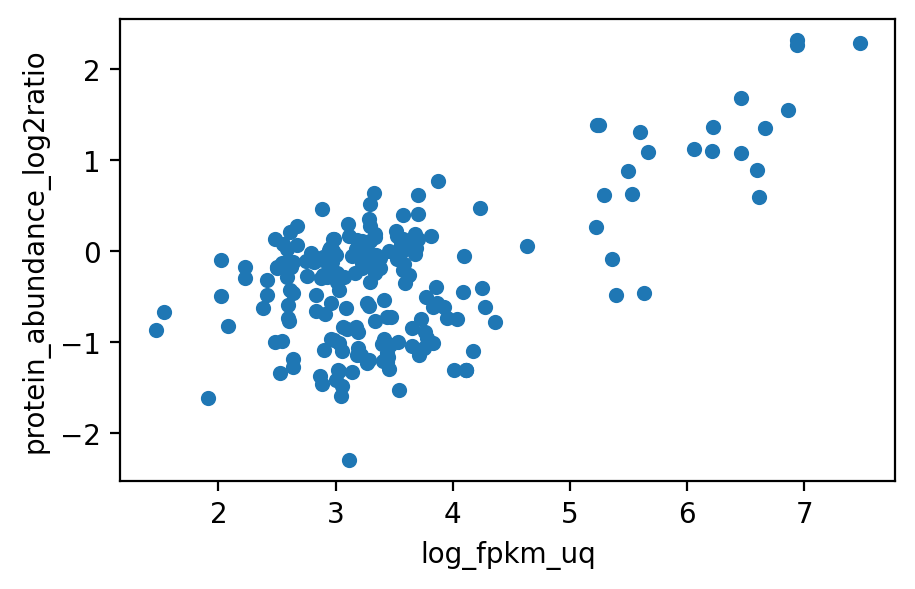

In [ ]:
import matplotlib
import numpy as np
plt.rcParams['figure.figsize'] = (5, 3)

combined_df['log_fpkm_uq'] = np.log(combined_df['fpkm_uq_unstranded'])
ScatterPlot = combined_df.plot.scatter(x='log_fpkm_uq', y='protein_abundance_log2ratio')

And finally we can generate a boxplot of RNA expression value split by mutation type present in the gene.

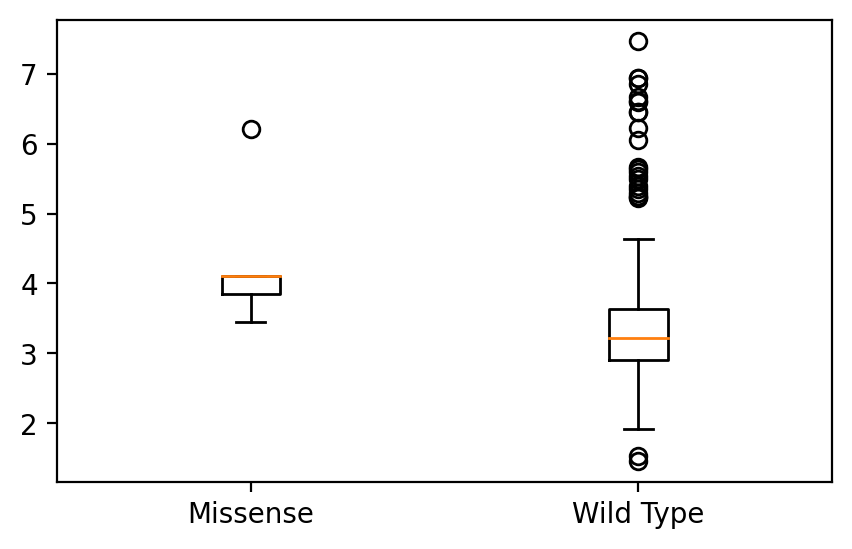

In [ ]:
mutated = combined_df[combined_df['Variant_Classification'] == 'Missense_Mutation']['log_fpkm_uq']
wildtype = combined_df[combined_df['Variant_Classification'] != 'Missense_Mutation']['log_fpkm_uq']
tmp = plt.boxplot(x=[mutated, wildtype], labels=['Missense', 'Wild Type'])